# Identify family interactions based on if they shared the same objects

This file does the following:
    1. fomulate communities based on the interactions with the same object
    2. Calculate innovations within each community 
    3. plot family interactions based on objects
    
Created by Grace Deng in August, 2020

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from datetime import datetime

from tqdm.notebook import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout
import community as community_louvain

## Load Data

### load parsed connection data

In [ ]:
parsed_data = pd.read_csv('outputs/conn_data_slice4.csv')

### load family data and write a find_family function

In [16]:
fam= pd.read_csv('../2_demographics/outputs/family_playerID.tsv', sep = '\t', index_col = 0)
# fam.head(n=10)

/Users/dengwenning/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [17]:
def find_fam(playerId):
    
    family = fam.loc[fam['playerID'] == playerId,'family'].tolist()
    if len(family):    
        fam_name = family[0].split('-')[-1]
    else:
        fam_name = fam_name = "UnKnown"
    
    return fam_name

check if every player has a last name (No!) and find the number of players in a family

In [ ]:
fam_player_dict = {}
player_fam_dict = {}
for i in data['playerID'].unique():
    if (i != -1) and (i != 0):
        family = fam.query('playerID == @i')['family'].values
        if len(family):
            family_name = family[0].split('-')[-1]
            player_fam_dict[i] = family_name
            if family_name in fam_player_dict.keys():
                fam_player_dict[family_name] = fam_player_dict[family_name]+1
            else:
                fam_player_dict[family_name] = 1


## Louvain

In [45]:
G = nx.from_pandas_edgelist(parsed_data, 'playerID', 'prev_playerID') 
partition = community_louvain.best_partition(G)

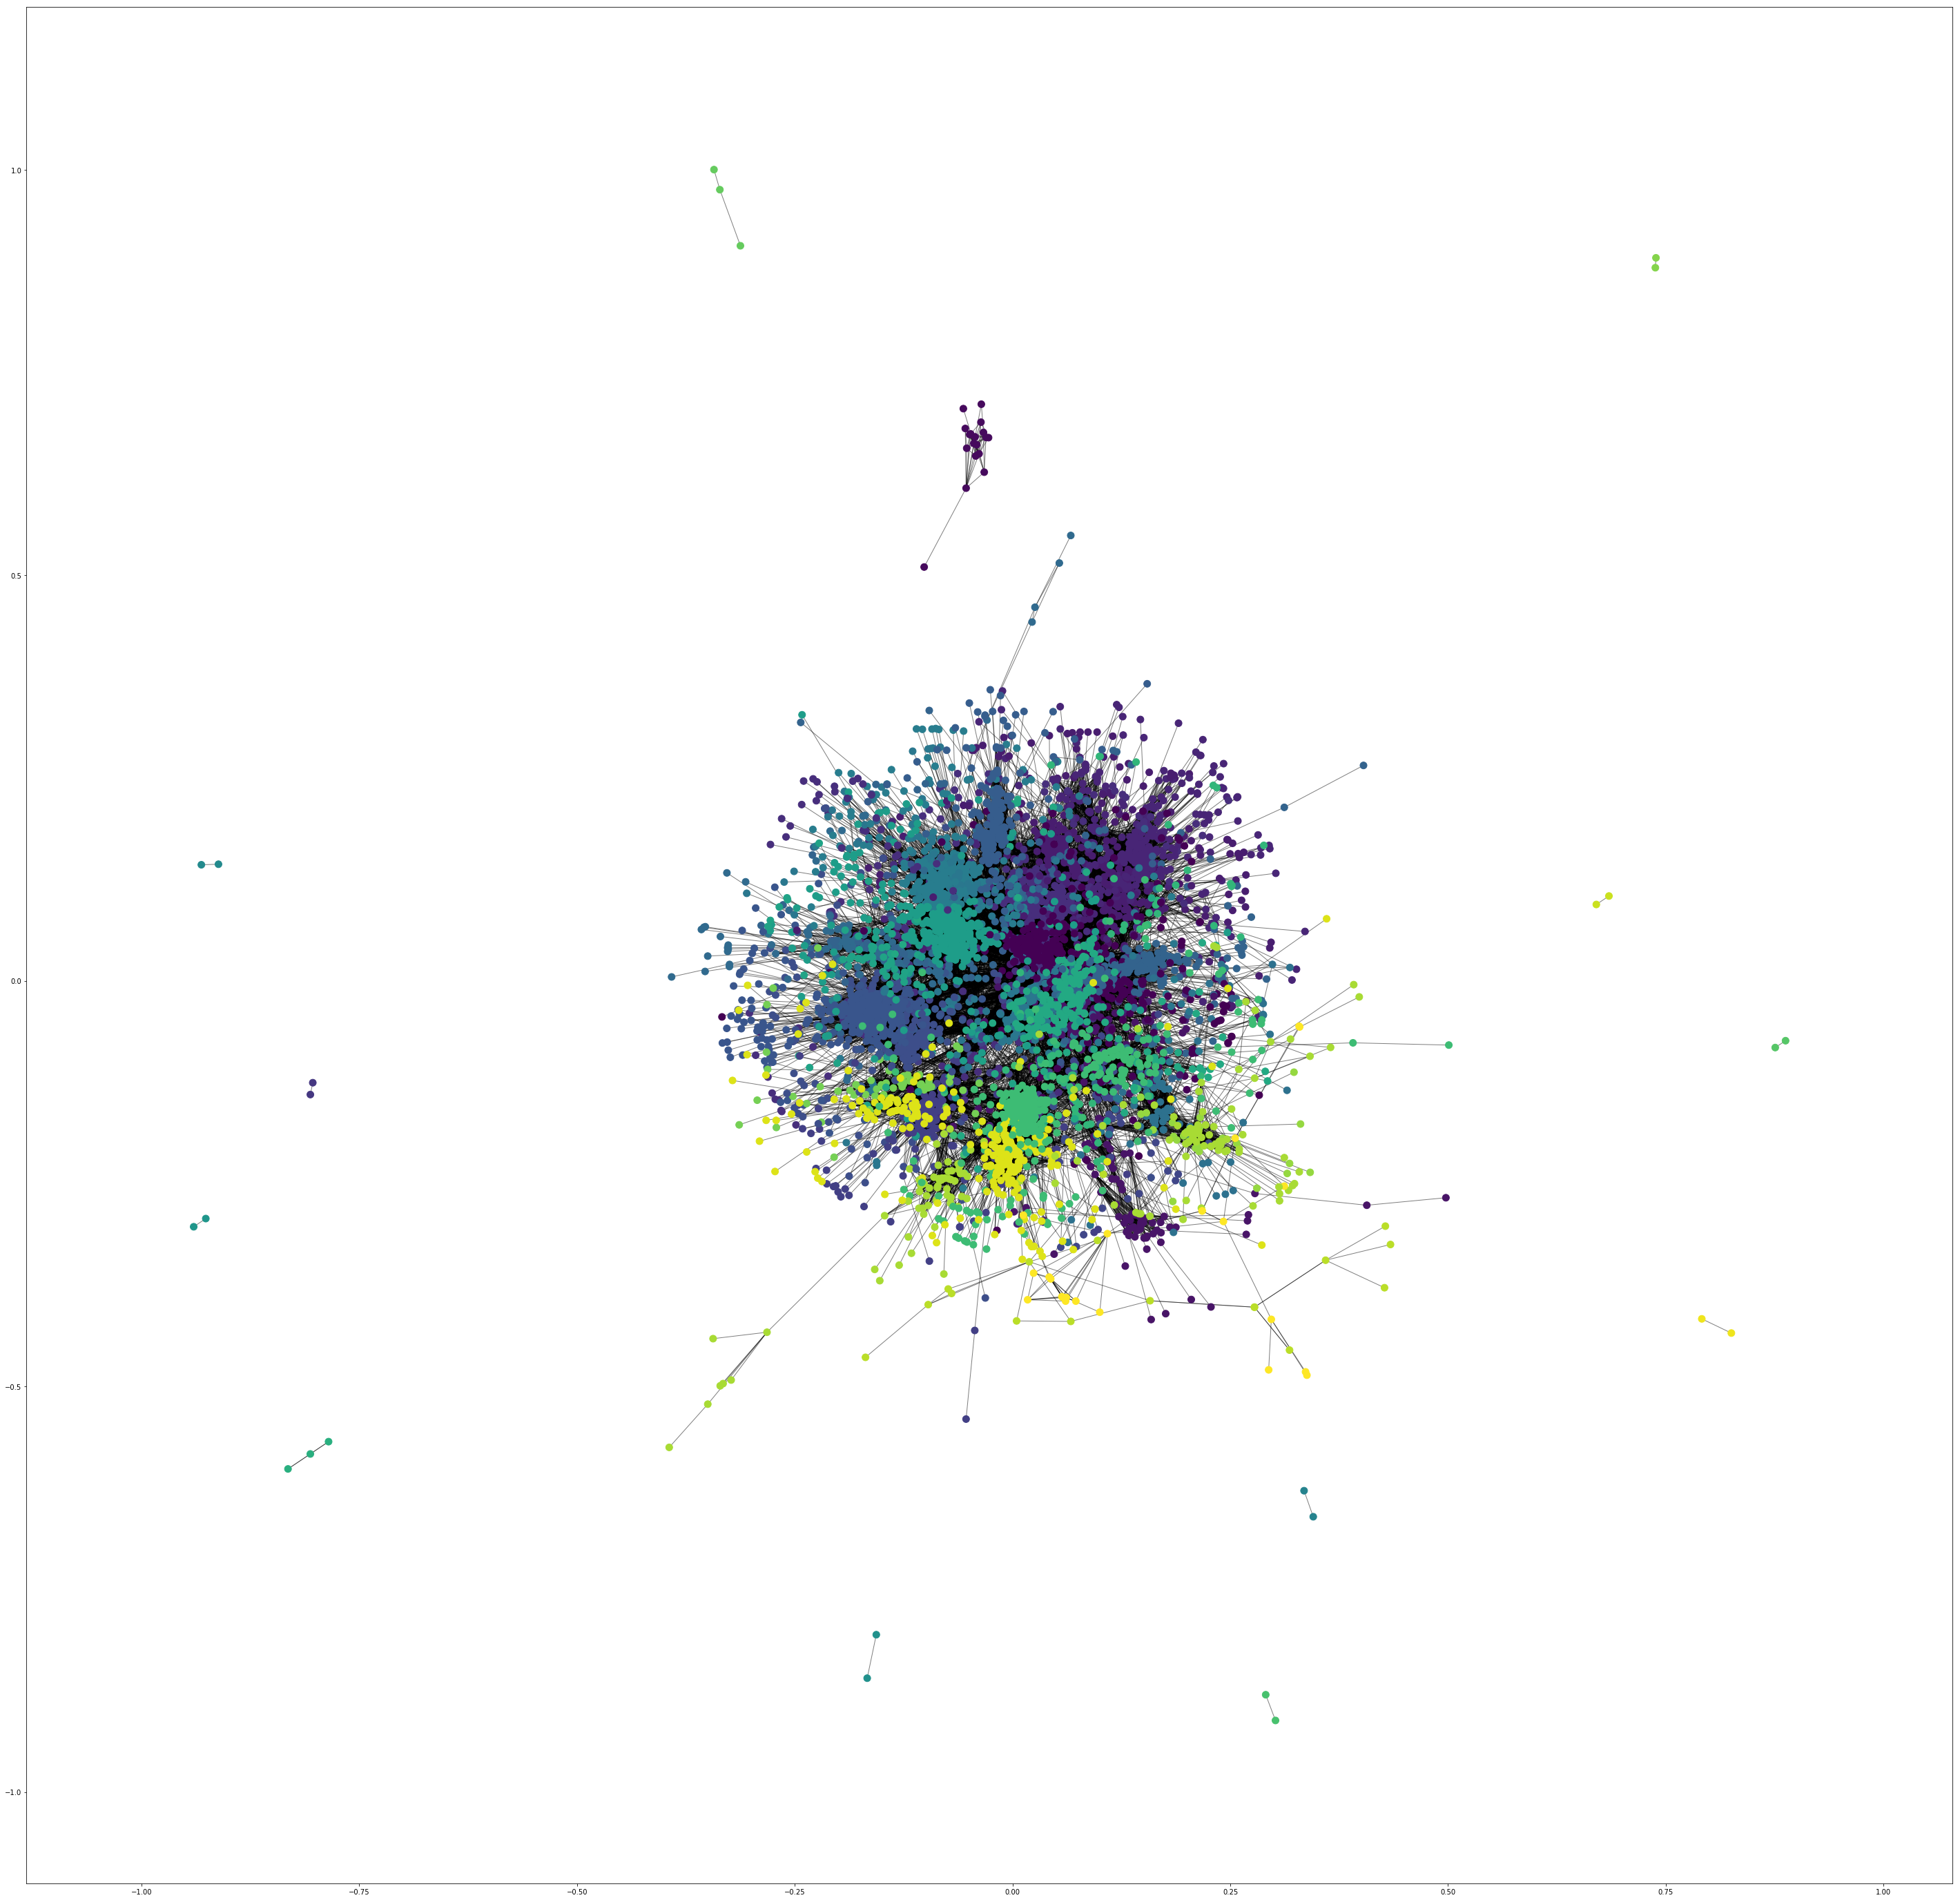

In [46]:
plt.figure(figsize=(50,50))
# pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=100, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# plt.savefig('louvain.png', dpi = 100)

Tag community to each player

In [97]:
def find_community(player):
    try:
        return partition[player]
    except KeyError:
        return np.nan

In [98]:
data_louvain = data.loc[data.playerID != -1].copy()
data_louvain['community'] = data_louvain['playerID'].apply(find_community)

In [99]:
data_louvain['objID'] = data_louvain['obj'].apply(lambda x: int_extract('[0-9]+', x))

In [105]:
data_louvain = data_louvain.dropna()
data_louvain.head()

,time,locX,locY,obj,playerID,community,objID
0,10.88,48,-217,48,2535863,38.0,48
1,12.38,50,-215,64,2535863,38.0,64
2818,125.00,0,-271,0,2535863,38.0,0
2819,125.88,2,-270,32,2535863,38.0,32
2821,127.53,4,-273,806,2535863,38.0,806


tag innovations by community

In [123]:
community_innovations = pd.DataFrame()

In [124]:
for i in data_louvain.community.unique():
    comm_subset = data_louvain.loc[data_louvain.community == i]
    comm_innovs = comm_subset.groupby(['objID'])['playerID'].apply(lambda x: x.tolist()[0]).to_frame().reset_index()
    comm_innovs_sum = comm_innovs.groupby(['playerID'])['objID'].count().to_frame().reset_index()
    comm_innovs_sum['community'] = i
    community_innovations = community_innovations.append(comm_innovs_sum)

In [ ]:
community_innovations = community_innovations.reset_index()

tag families and communities to each avatar

In [97]:
avatars = parsed_data.playerID.unique()

In [31]:
same_family = []
same_comm = []
for i in avatars:
    others = parsed_data.loc[parsed_data.playerID==i]['prev_playerID'].tolist()
    for j in others:
        try:
            same_family.append(player_fam_dict[i] == player_fam_dict[j])
        except KeyError: ##family name not defined
            same_family.append(np.nan)
        same_comm.append(partition[i] == partition[j])
        

In [69]:
with_fam_list = []
for i in range(len(same_family)):
    if (same_family[i] is True) or (same_family[i] is False):
        with_fam_list.append(i)


In [71]:
mydf = pd.DataFrame()
mydf['same_fam'] = same_family
mydf['same_comm'] = same_comm

In [73]:
mydf = mydf.dropna()
len(mydf)

130186

In [79]:
mydf['agreement'] = mydf.same_fam.eq(mydf.same_comm)

/Users/dengwenning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### summary statistics

What's the degree of correlation?

In [82]:
p_agree = len(mydf.loc[mydf.agreement==True])/len(mydf) 
p_agree

0.8754167114743521

How many families are there?

In [94]:
num_family = len(fam_player_dict.keys())
num_family

48

How many partitions are there?

In [88]:
num_partition = max(partition.values())
num_partition

39

create a player-family-community df

In [100]:
playerdf = pd.DataFrame()
playerdf['playerID'] = avatars
playerdf['family'] =playerdf['playerID'].map(find_fam)
playerdf['partition'] =playerdf['playerID'].map(lambda x: partition[x])

How many unique families are in each community?

In [116]:
comm_fam = playerdf.groupby('partition')['family'].apply(lambda x: len(set(x))).to_frame().reset_index()

(array([ 16.,   5.,   4.,   5.,   3.,   1.,   5.,   0.,   0.,   1.]),
 array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.]),
 <a list of 10 Patch objects>)

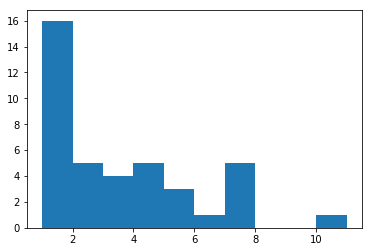

In [117]:
plt.hist(x = comm_fam['family'])

How many communities are families spread out into?

In [109]:
fam_comm = playerdf.groupby('family')['partition'].apply(lambda x: len(set(x))).to_frame().reset_index()

(array([ 31.,   3.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1. ,   4.4,   7.8,  11.2,  14.6,  18. ,  21.4,  24.8,  28.2,
         31.6,  35. ]),
 <a list of 10 Patch objects>)

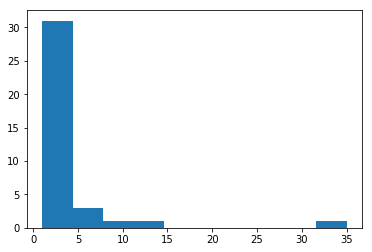

In [115]:
plt.hist(x = fam_comm['partition'])

## Plot individual connections

tag family names

In [34]:
grouped_with_fam = grouped.copy()
grouped_with_fam['player_fam'] = grouped_with_fam['playerID'].map(find_fam)
grouped_with_fam['prev_player_fam'] = grouped_with_fam['prev_playerID'].map(find_fam)

In [35]:
grouped_with_fam.head(n=10)

,playerID,prev_playerID,time,player_fam,prev_player_fam
0,2276905,2276906,1,ZABICKI,ZABICKI
1,2276905,2276909,22,ZABICKI,ZABICKI
2,2276905,2276914,4,ZABICKI,ZABICKI
3,2276905,2276922,4,ZABICKI,ZABICKI
4,2276905,2276929,2,ZABICKI,ZABICKI
5,2276905,2276930,1,ZABICKI,ZABICKI
6,2276905,2276931,1,ZABICKI,ZABICKI
7,2276905,2276941,5,ZABICKI,ZABICKI
8,2276905,2276954,1,ZABICKI,ZABICKI
9,2276906,2276905,1,ZABICKI,ZABICKI


plot player interactions

In [38]:
sorteddf = parsed_data.copy()
# sorteddf[['playerID','prev_playerID']]=np.sort(sorteddf[['playerID','prev_playerID']],1)
sortednew = sorteddf.groupby(['playerID','prev_playerID'])['time'].count().to_frame().reset_index()

In [39]:
sortednew['player_fam'] = sortednew['playerID'].map(find_fam)
sortednew['prev_player_fam'] = sortednew['prev_playerID'].map(find_fam)
sortednew.head()

,playerID,prev_playerID,time,player_fam,prev_player_fam
0,2276905,2276906,1,ZABICKI,ZABICKI
1,2276905,2276909,22,ZABICKI,ZABICKI
2,2276905,2276914,4,ZABICKI,ZABICKI
3,2276905,2276922,4,ZABICKI,ZABICKI
4,2276905,2276929,2,ZABICKI,ZABICKI


In [40]:
unique_fams = list(set(np.append(sortednew.player_fam.unique(), sortednew.prev_player_fam.unique())))
colors = {}
for i in unique_fams:
    colors[i] = list(np.random.choice(range(256), size=3)/256)

In [42]:
G = nx.from_pandas_edgelist(sortednew, 'playerID', 'prev_playerID') 
nodes = G.nodes()
color = [colors[find_fam(n)] for n in nodes] ##assign colors to nodes based on family

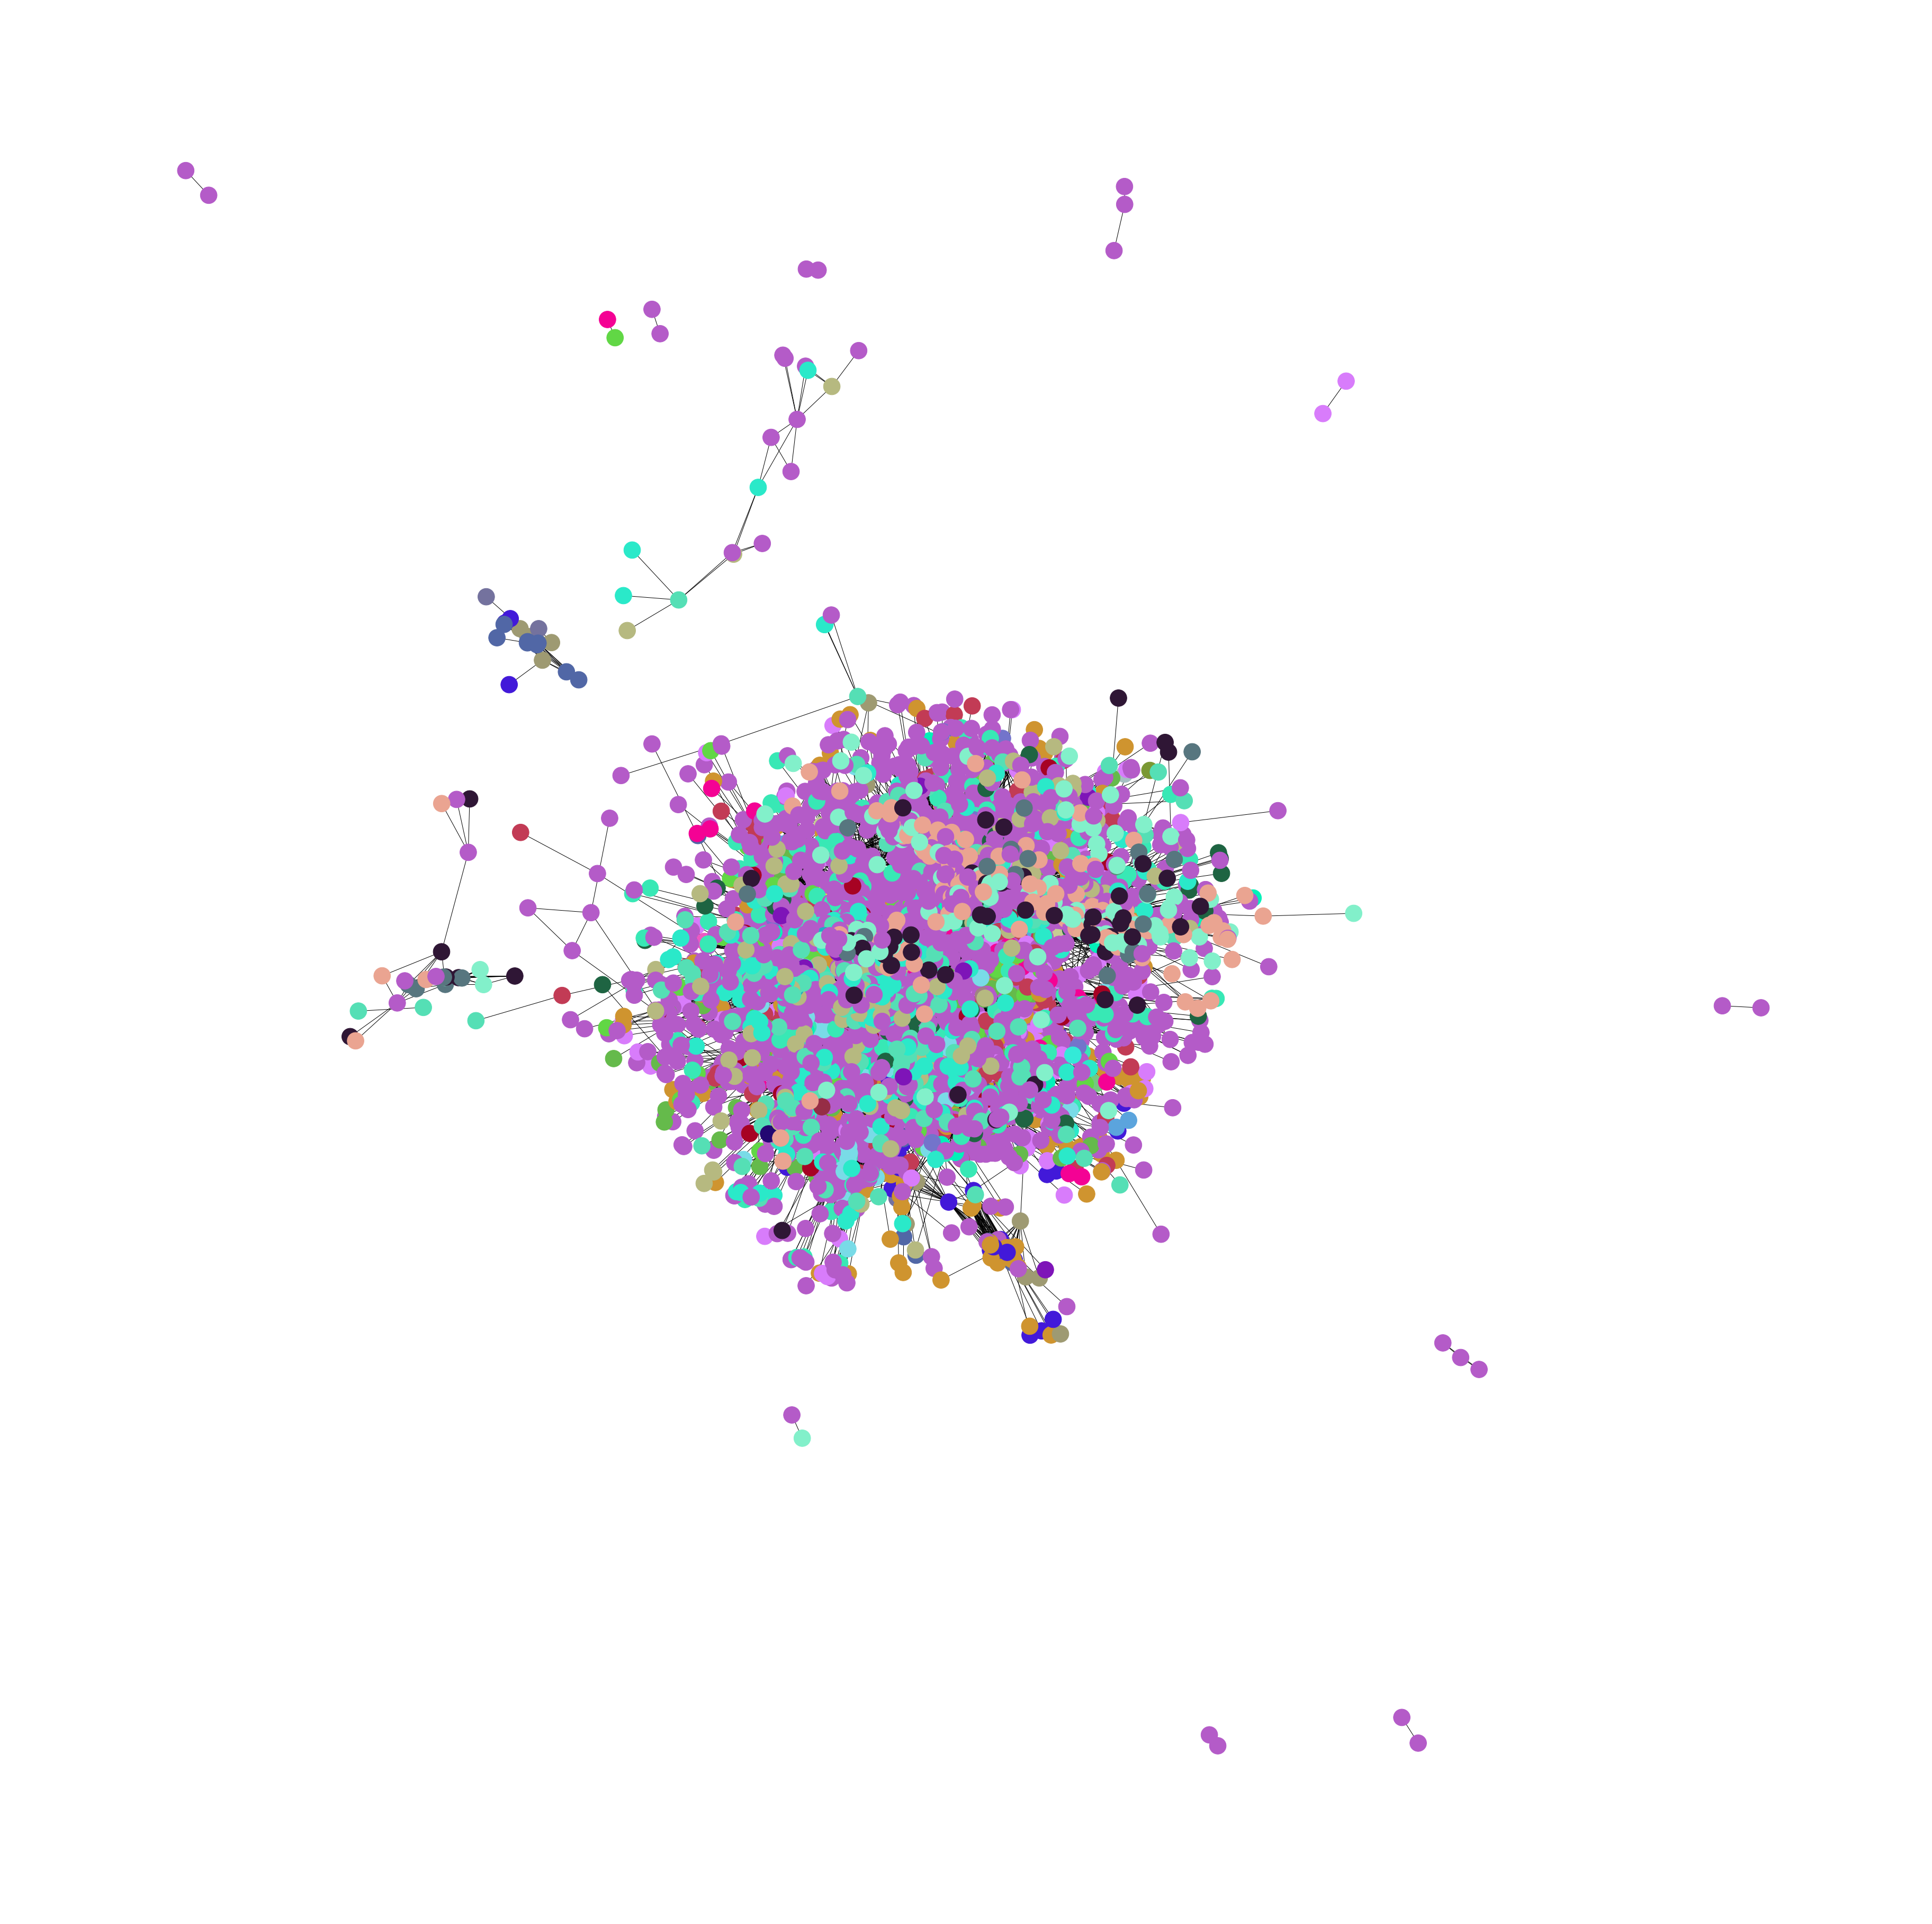

In [48]:
plt.figure(figsize=(50,50))
pos = nx.spring_layout(G, k=1/np.sqrt(len(nodes)), iterations=20) ##make nodes further apart
nx.draw(G, pos = pos, with_labels= False, node_color = color)
# plt.savefig('family2.png', dpi = 100)

## plot interactions by family

In [30]:
# sortednew = grouped.copy()
# sortednew[['player_fam','previous_player_fam']]=np.sort(sortednew[['player_fam','previous_player_fam']],1)
fam_df = grouped_with_fam.groupby(['player_fam','prev_player_fam'])['time'].count().to_frame().reset_index()

In [31]:
fam_df = fam_df.query('(player_fam != prev_player_fam) and (player_fam != "UnKnown") and (prev_player_fam != "UnKnown")')

turn df to graph representation

In [33]:
G2 = nx.from_pandas_edgelist(fam_df, 'prev_player_fam','player_fam', None, nx.DiGraph()) 

set node size proportional to family size

In [34]:
ns = [200*np.sqrt(fam_player_dict[i]) for i in G2.nodes]

set edge width proportional to number of interactions

In [37]:
s = sum(fam_df['time'].tolist())
ew = []
for (u,v) in G2.edges:
    times = fam_df.loc[(fam_df.prev_player_fam == u) & (fam_df.player_fam == v)]['time'].values[0]
    weight = 20*np.sqrt(times/s)
    ew = np.append(ew, weight)

In [38]:
len(ew) == len(G2.edges)

True

draw graph

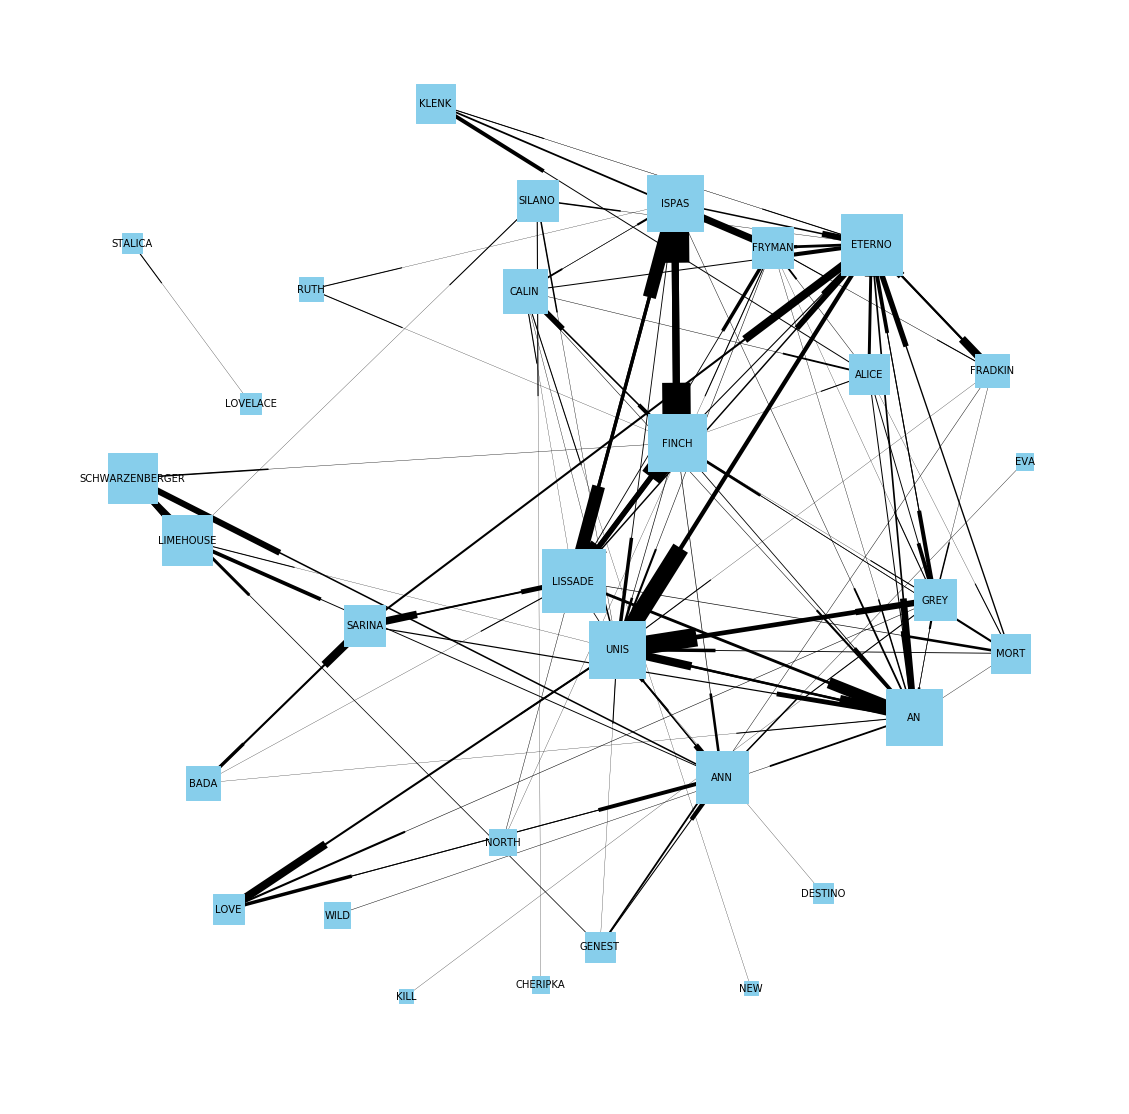

In [39]:
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G2, k=0.8, iterations=20) ##make nodes further apart
nx.draw(G2, pos=pos, with_labels= True, node_color='skyblue', width=ew, node_shape='s', node_size=ns, font_size=10)

plt.savefig('plots/fam_directed.png',dpi = 100)